In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
from keras.preprocessing.sequence import TimeseriesGenerator
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

In [2]:
def ts_idlist(df,idlist,window):
    X=[]
    y=[]
    feature_cols=df.columns.to_list()
    feature_cols.remove('ID')
    feature_cols.remove('RUL')
    for i in idlist:
            df_ID = df[df['ID']==i]
            df_ID = df_ID.drop(columns=['ID'])
            features = df_ID[feature_cols].to_numpy()
            target = df_ID[['RUL']].to_numpy()
            ts_generator = TimeseriesGenerator(features,target,length=window,sampling_rate=1,batch_size=1)
            for j in range(len(ts_generator)):
                x_temp, y_temp = ts_generator[j]
                X.append(x_temp[0])
                y.append(y_temp[0][0])
    X=np.array(X)
    y=np.array(y)
    return(X,y)

In [3]:
def get_ts(dataset_n,window):
    scale_train = MinMaxScaler()
    df=pd.read_csv("Train_{}.csv".format(dataset_n))
    cols_to_scale=df.columns.tolist()
    cols_to_scale.remove('ID')
    df[cols_to_scale] = pd.DataFrame(scale_train.fit_transform(df[cols_to_scale].values), columns=cols_to_scale, index=df.index)
    ID=np.unique(df['ID'])
    n=10
    k, m = divmod(len(ID), n)
    chunks=[ID[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n)]
    ID_validation=chunks[-1].tolist()
    ID_train=[i for i in ID if i not in ID_validation]
    X_validation,y_validation=ts_idlist(df,ID_validation,window)
    X_train,y_train=ts_idlist(df,ID_train,window)

    df=pd.read_csv("Test_{}.csv".format(dataset_n))
    df[cols_to_scale] = pd.DataFrame(scale_train.transform(df[cols_to_scale].values), columns=cols_to_scale, index=df.index)
    ID_test=np.unique(df['ID']).tolist()
    X_test,y_test=ts_idlist(df,ID_test,window)
    return(X_train,y_train,X_validation,y_validation,X_test,y_test,scale_train,cols_to_scale)

In [4]:
window=5,
dataset_n=1
X_train,y_train,X_validation,y_validation,X_test,y_test,scale_train,cols_to_scale=get_ts(1,5)

In [5]:
X_train.shape, y_train.shape, X_validation.shape, y_validation.shape, X_test.shape, y_test.shape

((17930, 5, 13), (17930,), (2201, 5, 13), (2201,), (12596, 5, 13), (12596,))

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(LSTM(
         units=100,
         return_sequences=True,
         input_shape=(5, 13)))
model.add(Dropout(0.2))
model.add(LSTM(
          units=100,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='relu'))
model.add(Activation("relu"))
model.compile(loss="mse", optimizer="rmsprop", metrics=['mse'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 100)            45600     
                                                                 
 dropout (Dropout)           (None, 5, 100)            0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 126,101
Trainable params: 126,101
Non-trai

In [7]:
cp = ModelCheckpoint('model/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [8]:
history=model.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=100, callbacks=[cp])

Epoch 1/100
557/561 [============================>.] - ETA: 0s - loss: 0.0158 - root_mean_squared_error: 0.1257

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


561/561 [==============================] - 20s 31ms/step - loss: 0.0158 - root_mean_squared_error: 0.1256 - val_loss: 0.0289 - val_root_mean_squared_error: 0.1701
Epoch 2/100
560/561 [============================>.] - ETA: 0s - loss: 0.0107 - root_mean_squared_error: 0.1034

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


561/561 [==============================] - 16s 29ms/step - loss: 0.0107 - root_mean_squared_error: 0.1034 - val_loss: 0.0282 - val_root_mean_squared_error: 0.1679
Epoch 3/100
560/561 [============================>.] - ETA: 0s - loss: 0.0103 - root_mean_squared_error: 0.1017

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


561/561 [==============================] - 16s 29ms/step - loss: 0.0103 - root_mean_squared_error: 0.1017 - val_loss: 0.0263 - val_root_mean_squared_error: 0.1622
Epoch 4/100
561/561 [==============================] - 9s 16ms/step - loss: 0.0102 - root_mean_squared_error: 0.1008 - val_loss: 0.0274 - val_root_mean_squared_error: 0.1657
Epoch 5/100
561/561 [==============================] - 9s 16ms/step - loss: 0.0099 - root_mean_squared_error: 0.0993 - val_loss: 0.0268 - val_root_mean_squared_error: 0.1638
Epoch 6/100
560/561 [============================>.] - ETA: 0s - loss: 0.0096 - root_mean_squared_error: 0.0981

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


561/561 [==============================] - 16s 29ms/step - loss: 0.0096 - root_mean_squared_error: 0.0981 - val_loss: 0.0250 - val_root_mean_squared_error: 0.1582
Epoch 7/100
560/561 [============================>.] - ETA: 0s - loss: 0.0094 - root_mean_squared_error: 0.0970

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


561/561 [==============================] - 16s 29ms/step - loss: 0.0094 - root_mean_squared_error: 0.0971 - val_loss: 0.0236 - val_root_mean_squared_error: 0.1536
Epoch 8/100
561/561 [==============================] - 9s 16ms/step - loss: 0.0092 - root_mean_squared_error: 0.0959 - val_loss: 0.0262 - val_root_mean_squared_error: 0.1619
Epoch 9/100
560/561 [============================>.] - ETA: 0s - loss: 0.0092 - root_mean_squared_error: 0.0958

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


561/561 [==============================] - 17s 30ms/step - loss: 0.0092 - root_mean_squared_error: 0.0958 - val_loss: 0.0234 - val_root_mean_squared_error: 0.1529
Epoch 10/100
561/561 [==============================] - 10s 17ms/step - loss: 0.0092 - root_mean_squared_error: 0.0957 - val_loss: 0.0236 - val_root_mean_squared_error: 0.1536
Epoch 11/100
559/561 [============================>.] - ETA: 0s - loss: 0.0092 - root_mean_squared_error: 0.0960

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


561/561 [==============================] - 18s 32ms/step - loss: 0.0092 - root_mean_squared_error: 0.0959 - val_loss: 0.0234 - val_root_mean_squared_error: 0.1529
Epoch 12/100
561/561 [==============================] - 10s 17ms/step - loss: 0.0092 - root_mean_squared_error: 0.0958 - val_loss: 0.0240 - val_root_mean_squared_error: 0.1549
Epoch 13/100
561/561 [==============================] - 9s 15ms/step - loss: 0.0091 - root_mean_squared_error: 0.0952 - val_loss: 0.0244 - val_root_mean_squared_error: 0.1562
Epoch 14/100
561/561 [==============================] - 8s 15ms/step - loss: 0.0091 - root_mean_squared_error: 0.0953 - val_loss: 0.0250 - val_root_mean_squared_error: 0.1581
Epoch 15/100
561/561 [==============================] - 8s 15ms/step - loss: 0.0090 - root_mean_squared_error: 0.0950 - val_loss: 0.0237 - val_root_mean_squared_error: 0.1540
Epoch 16/100
561/561 [==============================] - 8s 15ms/step - loss: 0.0091 - root_mean_squared_error: 0.0954 - val_loss: 0.0234

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


561/561 [==============================] - 15s 27ms/step - loss: 0.0089 - root_mean_squared_error: 0.0944 - val_loss: 0.0233 - val_root_mean_squared_error: 0.1526
Epoch 30/100
561/561 [==============================] - 9s 16ms/step - loss: 0.0089 - root_mean_squared_error: 0.0941 - val_loss: 0.0244 - val_root_mean_squared_error: 0.1561
Epoch 31/100
561/561 [==============================] - 10s 17ms/step - loss: 0.0088 - root_mean_squared_error: 0.0938 - val_loss: 0.0239 - val_root_mean_squared_error: 0.1546
Epoch 32/100
561/561 [==============================] - 9s 17ms/step - loss: 0.0089 - root_mean_squared_error: 0.0942 - val_loss: 0.0235 - val_root_mean_squared_error: 0.1534
Epoch 33/100
561/561 [==============================] - 9s 16ms/step - loss: 0.0088 - root_mean_squared_error: 0.0937 - val_loss: 0.0235 - val_root_mean_squared_error: 0.1531
Epoch 34/100
561/561 [==============================] - 10s 18ms/step - loss: 0.0088 - root_mean_squared_error: 0.0938 - val_loss: 0.024

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


561/561 [==============================] - 17s 30ms/step - loss: 0.0088 - root_mean_squared_error: 0.0938 - val_loss: 0.0232 - val_root_mean_squared_error: 0.1524
Epoch 40/100
561/561 [==============================] - 10s 18ms/step - loss: 0.0088 - root_mean_squared_error: 0.0936 - val_loss: 0.0256 - val_root_mean_squared_error: 0.1601
Epoch 41/100
561/561 [==============================] - 9s 17ms/step - loss: 0.0087 - root_mean_squared_error: 0.0935 - val_loss: 0.0248 - val_root_mean_squared_error: 0.1576
Epoch 42/100
561/561 [==============================] - 10s 17ms/step - loss: 0.0087 - root_mean_squared_error: 0.0935 - val_loss: 0.0239 - val_root_mean_squared_error: 0.1545
Epoch 43/100
561/561 [==============================] - 10s 17ms/step - loss: 0.0087 - root_mean_squared_error: 0.0933 - val_loss: 0.0244 - val_root_mean_squared_error: 0.1562
Epoch 44/100
561/561 [==============================] - 9s 17ms/step - loss: 0.0087 - root_mean_squared_error: 0.0934 - val_loss: 0.02

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


561/561 [==============================] - 16s 28ms/step - loss: 0.0087 - root_mean_squared_error: 0.0934 - val_loss: 0.0223 - val_root_mean_squared_error: 0.1493
Epoch 49/100
561/561 [==============================] - 9s 16ms/step - loss: 0.0086 - root_mean_squared_error: 0.0930 - val_loss: 0.0226 - val_root_mean_squared_error: 0.1505
Epoch 50/100
561/561 [==============================] - 9s 15ms/step - loss: 0.0087 - root_mean_squared_error: 0.0931 - val_loss: 0.0255 - val_root_mean_squared_error: 0.1596
Epoch 51/100
561/561 [==============================] - 9s 15ms/step - loss: 0.0086 - root_mean_squared_error: 0.0930 - val_loss: 0.0234 - val_root_mean_squared_error: 0.1529
Epoch 52/100
561/561 [==============================] - 9s 16ms/step - loss: 0.0086 - root_mean_squared_error: 0.0928 - val_loss: 0.0245 - val_root_mean_squared_error: 0.1565
Epoch 53/100
561/561 [==============================] - 9s 16ms/step - loss: 0.0086 - root_mean_squared_error: 0.0928 - val_loss: 0.0233 

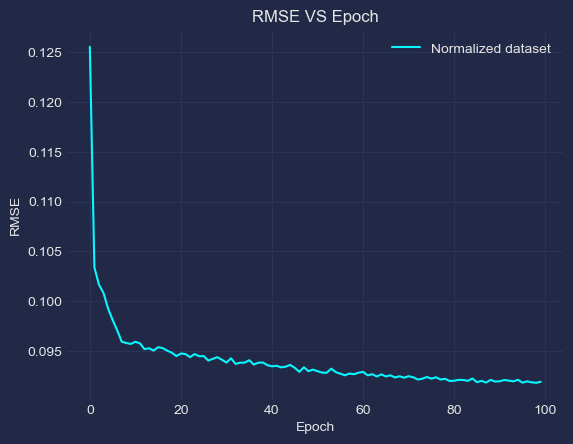

In [9]:
import matplotlib.pyplot as plt
import mplcyberpunk
plt.style.use('cyberpunk')
plt.plot(history.history['root_mean_squared_error'])
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend([ 'Normalized dataset'])
plt.title('RMSE VS Epoch')
df_history=pd.DataFrame()
df_history['root_mean_squared_error']=history.history['root_mean_squared_error']
# df_history.to_pickle("./rmse_normalized.pkl") 

In [10]:
from tensorflow.keras.models import load_model
model = load_model('model/')

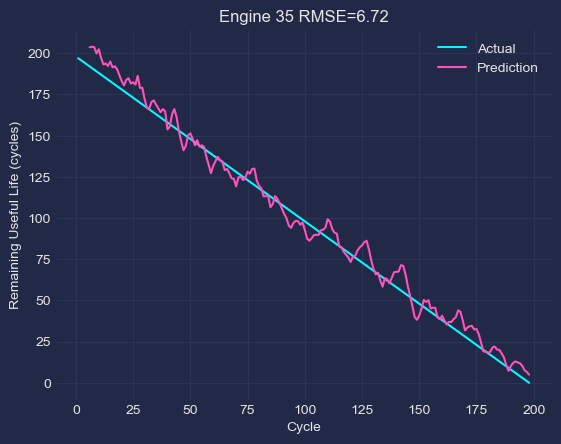

In [100]:
id = random.randint(1,100)
dataset_n=1
window=5
df=pd.read_csv("Test_{}.csv".format(dataset_n))
df=df[df['ID']==id]
df_pred=df.copy()
df_pred[cols_to_scale] = pd.DataFrame(scale_train.transform(df_pred[cols_to_scale].values), columns=cols_to_scale, index=df_pred.index)
X_id,y_id=ts_idlist(df_pred,[id],window)
test_predictions = model.predict(X_id).flatten()
df_pred = df_pred.iloc[window:,:]
df_pred['RUL']=test_predictions.tolist()
df_pred[cols_to_scale] = pd.DataFrame(scale_train.inverse_transform(df_pred[cols_to_scale].values), columns=cols_to_scale, index=df_pred.index)

import matplotlib.pyplot as plt
import mplcyberpunk
plt.style.use('cyberpunk')
plt.ylabel('Remaining Useful Life (cycles)')
plt.xlabel('Cycle')
plt.title('Engine {} RMSE={:.2f}'.format(id,np.sqrt(metrics.mean_squared_error(df['RUL'][window:],df_pred['RUL']))))
#plt.plot(train_results['Actuals'])
plt.plot(df['Cycle'],df['RUL'])
plt.plot(df_pred['Cycle'],df_pred['RUL'])
plt.legend([ 'Actual','Prediction'])

In [12]:
#df_pred.to_pickle("./pred_normalized.pkl")
#df.to_pickle("./actual_normalized.pkl")

In [49]:
df_pred_raw = pd.read_pickle("./pred_raw.pkl")
df_history_raw = pd.read_pickle("./rmse_raw.pkl")

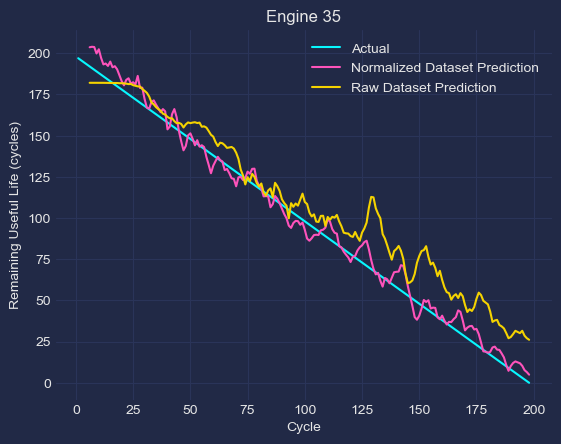

In [52]:
id = random.randint(1,100)
id=35
dataset_n=1
window=5
df=pd.read_csv("Test_{}.csv".format(dataset_n))
df=df[df['ID']==id]
df_pred=df.copy()
df_pred[cols_to_scale] = pd.DataFrame(scale_train.transform(df_pred[cols_to_scale].values), columns=cols_to_scale, index=df_pred.index)
X_id,y_id=ts_idlist(df_pred,[id],window)
test_predictions = model.predict(X_id).flatten()
df_pred = df_pred.iloc[window:,:]
df_pred['RUL']=test_predictions.tolist()
df_pred[cols_to_scale] = pd.DataFrame(scale_train.inverse_transform(df_pred[cols_to_scale].values), columns=cols_to_scale, index=df_pred.index)

import matplotlib.pyplot as plt
import mplcyberpunk
plt.style.use('cyberpunk')
plt.ylabel('Remaining Useful Life (cycles)')
plt.xlabel('Cycle')
#plt.title('Engine {} RMSE={:.2f}'.format(id,np.sqrt(metrics.mean_squared_error(df['RUL'][window:],df_pred['RUL']))))
#plt.title('Engine {} RMSE={:.2f}'.format(id,np.sqrt(metrics.mean_squared_error(df['RUL'][window:],df_pred_raw['RUL']))))
plt.title('Engine {}'.format(id))
#plt.plot(train_results['Actuals'])
plt.plot(df['Cycle'],df['RUL'])
plt.plot(df_pred['Cycle'],df_pred['RUL'])
plt.plot(df_pred_raw['Cycle'],df_pred_raw['RUL'])
plt.legend([ 'Actual','Normalized Dataset Prediction','Raw Dataset Prediction'])

In [41]:
#use an arbitrary dataset to scale the loss of the raw dataset
df_pred_raw = pd.read_pickle("./pred_raw.pkl")
df_pred_raw=df_pred_raw.iloc[93:,:]
len(df_pred_raw)

100

In [42]:
len(df_history_raw)

100

In [43]:
x=df_history_raw['root_mean_squared_error'].tolist()
df_pred_raw['RUL']=x
df_pred_raw

,ID,Cycle,LPCOutletTemperatureR,HPCOutletTemperatureR,LPTOutletTemperatureR,HPCOutletPressurePsia,PhysicalFanSpeedRpm,HPCOutletStaticPressurePsia,RatioofFuelFlowtoPs30PpsPsia,CorrectedFanSpeed,BypassRatio,BleedEntalphy,HighPressureTurbinesCoolAirFlow,LowPressureTurbinesCoolAirFlow,RUL
4366,35,99,643.18,1588.60,1408.21,553.47,2388.17,47.55,520.89,2388.10,8.4698,393,38.72,23.2590,111.331352
4367,35,100,642.96,1595.50,1416.78,552.73,2388.17,47.70,521.35,2388.07,8.4555,393,38.63,23.2752,104.415726
4368,35,101,642.41,1591.71,1416.44,552.51,2388.16,47.62,521.50,2388.16,8.4747,392,38.94,23.2908,100.511620
4369,35,102,642.73,1592.70,1413.16,553.43,2388.11,47.84,521.48,2388.11,8.4291,393,38.71,23.2618,96.945427
4370,35,103,642.70,1593.43,1408.28,553.13,2388.08,47.68,521.49,2388.16,8.4371,393,38.86,23.2296,93.609261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4461,35,194,643.48,1601.37,1419.80,552.04,2388.20,47.99,520.02,2388.19,8.4845,397,38.58,23.2015,38.823475
4462,35,195,643.42,1599.51,1429.31,551.93,2388.20,48.05,520.02,2388.22,8.5088,395,38.69,23.0403,38.746075
4463,35,196,643.42,1598.79,1424.96,551.79,2388.23,47.82,519.77,2388.20,8.5005,397,38.65,23.1273,38.407658
4464,35,197,643.39,1596.37,1427.93,552.06,2388.23,48.26,520.53,2388.18,8.5375,394,38.39,23.0200,38.530067


In [44]:
df_pred_raw[cols_to_scale] = pd.DataFrame(scale_train.transform(df_pred_raw[cols_to_scale].values), columns=cols_to_scale, index=df_pred_raw.index)

In [45]:
df_pred_raw

,ID,Cycle,LPCOutletTemperatureR,HPCOutletTemperatureR,LPTOutletTemperatureR,HPCOutletPressurePsia,PhysicalFanSpeedRpm,HPCOutletStaticPressurePsia,RatioofFuelFlowtoPs30PpsPsia,CorrectedFanSpeed,BypassRatio,BleedEntalphy,HighPressureTurbinesCoolAirFlow,LowPressureTurbinesCoolAirFlow,RUL
4366,35,0.271468,0.593373,0.382821,0.438217,0.582931,0.409091,0.416667,0.469083,0.323529,0.557522,0.416667,0.449612,0.503728,0.308397
4367,35,0.274238,0.527108,0.533246,0.582883,0.463768,0.409091,0.505952,0.567164,0.279412,0.502501,0.416667,0.379845,0.526098,0.289240
4368,35,0.277008,0.361446,0.450621,0.577144,0.428341,0.393939,0.458333,0.599147,0.411765,0.576376,0.333333,0.620155,0.547639,0.278426
4369,35,0.279778,0.457831,0.472204,0.521776,0.576490,0.318182,0.589286,0.594883,0.338235,0.400923,0.416667,0.441860,0.507595,0.268547
4370,35,0.282548,0.448795,0.488119,0.439399,0.528180,0.272727,0.494048,0.597015,0.411765,0.431705,0.416667,0.558140,0.463132,0.259305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4461,35,0.534626,0.683735,0.661216,0.633862,0.352657,0.454545,0.678571,0.283582,0.455882,0.614082,0.750000,0.341085,0.424330,0.107544
4462,35,0.537396,0.665663,0.620667,0.794396,0.334944,0.454545,0.714286,0.283582,0.500000,0.707580,0.583333,0.426357,0.201740,0.107330
4463,35,0.540166,0.665663,0.604971,0.720966,0.312399,0.500000,0.577381,0.230277,0.470588,0.675644,0.750000,0.395349,0.321872,0.106392
4464,35,0.542936,0.656627,0.552213,0.771101,0.355878,0.500000,0.839286,0.392324,0.441176,0.818007,0.500000,0.193798,0.173709,0.106731


In [46]:
df_history_raw['root_mean_squared_error']=df_pred_raw['RUL'].tolist()
df_history_raw

,root_mean_squared_error
0,0.308397
1,0.289240
2,0.278426
3,0.268547
4,0.259305
...,...
95,0.107544
96,0.107330
97,0.106392
98,0.106731


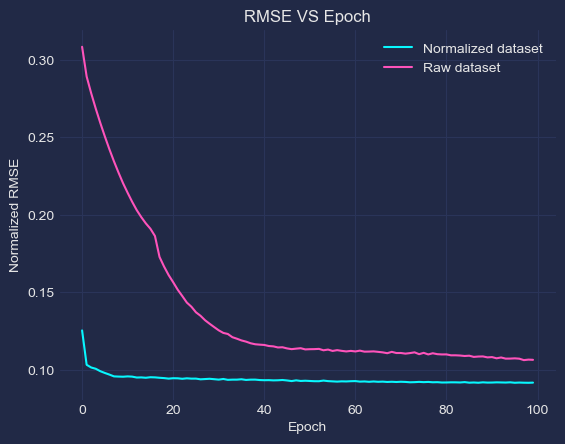

In [47]:
import matplotlib.pyplot as plt
import mplcyberpunk
plt.style.use('cyberpunk')
plt.plot(history.history['root_mean_squared_error'])
plt.plot(df_history_raw['root_mean_squared_error'])
plt.ylabel('Normalized RMSE')
plt.xlabel('Epoch')
plt.legend([ 'Normalized dataset','Raw dataset'])
plt.title('RMSE VS Epoch')
df_history=pd.DataFrame()
df_history['root_mean_squared_error']=history.history['root_mean_squared_error']
df_history.to_pickle("./rmse_normalized.pkl") 